# Find and Download NASA PACE L1 Data Example

## Requirements
Use of this notebook requires that your EarthData credentials be in .netrc file within your user directory.

```
machine urs.earthdata.nasa.gov
login your-login-here
password your-password-here
```

## Import Required Packages

In [1]:
from datetime import datetime
import os
import requests
import shutil
import time
import matplotlib

## Helper Functions

In [15]:
def find_cmr_items(sensor: str, begin_datetime: datetime = datetime(2024,4,1), end_datetime: datetime = datetime(2100,12,31,23,59,59), 
               lat_min: float = -90.000, lat_max:float = 90.000, lon_min: float = -180.000, lon_max: float = 180.000, 
               page_size: int = 2000, page_num: int = 1, verbose: bool = True) -> list:
    
    """
    Find relevant datasets/files using the NASA Common Metadata Repository.
    
    :param sensor: A string indicating the sensor of interest. Partial strings are accepted. e.g. HARP instead of PACE_HARP2
    :param begin_datetime: The point in time to start searching for data.
    :param end_datetime: The point in time to stop searching for data.
    :param lat_min: The minimum bounding latitude. Valid between -90 and 90.
    :param lat_max: The maximum bounding latitude. Valid between -90 and 90.
    :param lon_min: The minimum bounding longitude. Valid between -180 and 180.
    :param lon_max: The maximum bounding longitude. Valid between -180 and 180.
    :param page_size: The number of items to return for each request. Maximum is 2000.
    :param page_num: The page to return.
    :param verbose: If True, messages are printed to console. 
    :return: A list of CMR items, which provide the file download location and associated metadata.
    """
    
    bdt = begin_datetime.strftime('%Y-%m-%dT%H:%M:%SZ')
    edt = end_datetime.strftime('%Y-%m-%dT%H:%M:%SZ')
    base = 'https://cmr.earthdata.nasa.gov/search/granules.umm_json'
    params = {'provider': 'OB*',
              'options[provider][pattern]':'true',
              'short_name': f"*{sensor}*",
              'options[short_name][pattern]':'true',
              'page_size': page_size,
              'page_num': page_num,
              'temporal': f'{bdt},{edt}',
              'bounding_box': f"{lon_min},{lat_min},{lon_max},{lat_max}"}
    
    with requests.get(base, params = params) as response:
        if response.status_code != requests.codes.ok:
            raise ConnectionError(response.reason)
        data = response.json()
        hits, took, items = (data['hits'], data['took'], data['items'])
        if verbose is True:
            msg = f"Request took {took} milliseconds to complete."
            print(msg)
    if hits == 0:
        if verbose is True:
            print('No files found.')
        return None
    else:
        if verbose is True:
            print(f"Found {len(items)} files.")
        return items
    
    
def download_cmr_files(items: list, save_directory: os.path = os.getcwd(), overwrite: bool = False, verbose: bool = True) -> None:
    """
    Download NASA files.
    
    :param items: A list of items derived from the find_cmr_items function.
    :param save_directory: The directory you want to save data to.
    :param overwrite: Set to True if you want to overwrite data that already exists.
    :param verbose: Set to True if you want info messages printed to console.
    :return: None    
    """
    
    os.makedirs(save_directory, exist_ok = True)
    for item in items:
        umm = item['umm']
        download_url = umm['RelatedUrls'][0]['URL']
        if '.nc' not in download_url:
            download_url = umm['RelatedUrls'][1]['URL']
        save_filename = download_url.split('/')[-1]
        save_filepath = os.path.normpath(os.path.join(save_directory, save_filename))
        if os.path.isfile(save_filepath) and overwrite is False:
            continue
        with requests.get(download_url, stream = True) as req:
            with open(save_filepath,'wb') as fileobj:
                shutil.copyfileobj(req.raw, fileobj)
        if not os.path.isfile(save_filepath):
            raise FileNotFoundError(save_filepath)
        else:
            if verbose is True:
                print(f'Downloaded {save_filename}')

### Define Sensor and Spatial/Temporal Bounds

In [16]:
lat_min = 41
lat_max = 47
lon_min = -130
lon_max = -123
begin_datetime = datetime(2024,4,11,0,0,0)
end_datetime = datetime(2024,4,11,23,59,59)
sensor = 'OCI*L3*CHL' #Some Other Options: 'OCI*L1A', 'OCI*L1B', 'OCI*L1C', You could also try 'HARP' and 'SPEX' for the other sensors.

### Find Relevant Datasets

In [17]:
oci_items = find_cmr_items(sensor, begin_datetime = begin_datetime, end_datetime = end_datetime, lat_min = lat_min, lat_max = lat_max, lon_min = lon_min, lon_max = lon_max)

Request took 616 milliseconds to complete.
Found 2 files.


In [19]:
print('Download URLs...')
for item in oci_items:
    print(item['umm']['RelatedUrls'][1]['URL'])

Download URLs...
https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240411.L3m.DAY.CHL.V1_0_0.chlor_a.0p1deg.NRT.nc
https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240411.L3m.DAY.CHL.V1_0_0.chlor_a.4km.NRT.nc


### Download Files

In [21]:
%%time
overwrite = True
download_cmr_files(oci_items, overwrite = overwrite)

Downloaded PACE_OCI.20240411.L3m.DAY.CHL.V1_0_0.chlor_a.0p1deg.NRT.nc
Downloaded PACE_OCI.20240411.L3m.DAY.CHL.V1_0_0.chlor_a.4km.NRT.nc
CPU times: user 248 ms, sys: 82.8 ms, total: 331 ms
Wall time: 11.5 s


### Open A File

In [15]:
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [16]:
filename = 'PACE_OCI.20240411.L3m.DAY.CHL.V1_0_0.chlor_a.4km.NRT.nc'

In [17]:
import os
import xarray as xr
from typing import NamedTuple

class BoundingBox(NamedTuple):
    lat_min: float
    lat_max: float
    lon_min: float
    lon_max: float

GEBCO_BBOX =  BoundingBox(lat_min = 39, lat_max = 51, lon_min = -140, lon_max = -123.75)

def import_gebco(filepath: os.path = '/home/jovyan/oregon-shelf-mhw/data/gebco/GEBCO_2023.nc', bounding_box: object = GEBCO_BBOX) -> xr.Dataset:
    """
    This function will import a GEBCO file, slice it by latitude and longitude, and then recalculate depth as the inverse of elevation.
    All original data and attributes are retained.
    
    
    :param filepath: The filepath of the GEBCO file. Recommend using the absolute filepath.
    :param bounding_box: A class object (NamedTuple) with the attributes of lat_min, lat_max, lon_min, and lon_max. 
    :return: The GEBCO file data as an xarray dataset.
    """
    
    _ds = xr.open_dataset(filepath)
    _ds = _ds.sel(lat = slice(bounding_box.lat_min,bounding_box.lat_max), 
                  lon = slice(bounding_box.lon_min,bounding_box.lon_max)) # Slice the dataset by latitude and longitude.
    _ds['depth'] = _ds.elevation * -1
    return _ds


In [18]:

bbox = BoundingBox(lat_min = 17, lat_max = 32, lon_min = -98, lon_max = -80)

gebco = import_gebco(bounding_box = bbox)
gebco = gebco.where(gebco.depth <=0, drop = True)
landx, landy = np.meshgrid(gebco.lon, gebco.lat)
landz = gebco.depth

gebco_cmap = matplotlib.colormaps.get_cmap('Grays')
gebco_cmap.set_under('gray')

In [19]:
ds = xr.open_dataset(filename)
ds = ds.sortby(['lat','lon'])
ds = ds.sel(lat = slice(17,32),lon = slice(-98, -80))
ds['chlor_a'] = ds['chlor_a'].where(ds['chlor_a'] <= 35, np.nan)

In [27]:
ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 432, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17.02 17.06 17.1 17.15 ... 31.85 31.9 31.94 31.98
  * lon      (lon) float32 -97.98 -97.94 -97.9 -97.85 ... -80.1 -80.06 -80.02
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    palette  (rgb, eightbitcolor) uint8 ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240411.L3m.DAY.CHL.V1_0_0.c...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/v1
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         5900117
    data_minimum:                      0.0022643511
    data_maximum:                      99.080376

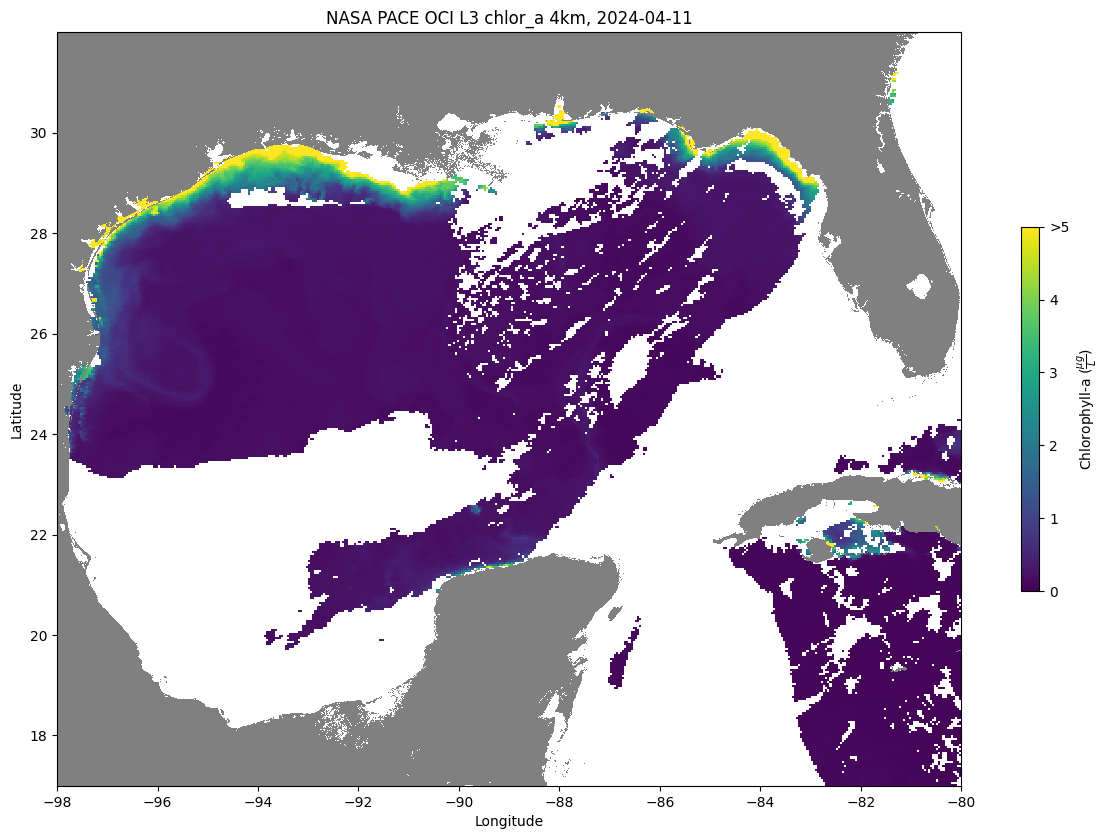

In [26]:
x, y = np.meshgrid(ds.lon, ds.lat)
z = ds.chlor_a

fig, ax = plt.subplots(1,1, figsize = (11,8.5), constrained_layout = True)

p = ax.pcolormesh(x,y,z, cmap = 'viridis', vmin = 0, vmax = 5)
cbar = fig.colorbar(p, ax = ax, label = r'Chlorophyll-a ($\frac{{\mu}g}{L}$)', shrink = 0.45, ticks = [0, 1,2,3,4,5])
cbar.ax.set_yticklabels(['0','1','2','3','4','>5'])

ax.set_box_aspect((32-17)/(98-80))
ax.set_title('NASA PACE OCI L3 chlor_a 4km, 2024-04-11')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.pcolormesh(landx, landy, landz, cmap = gebco_cmap, zorder = 1, vmin = 0, vmax = 0.0001)


plt.savefig('pace_l3_gulf.jpg', dpi = 600)